**Imports**

In [9]:
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.calculations.calculations import calculate_energy
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.rulebased import rule_based_energy_flow

**Definition des Green Energy Ecosystems**

In [10]:
# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 
longitude=4.208611 
azimuth=180 
albedo=0.2 

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # MWh
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # MWh
charging_rate = 10  # Lade-/Entladerate [MW/h]
discharging_rate = 10

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

# Strompreis
export_factor = 0.25   # Anteil vom Spotpreis für Einspeisung
price_low_quant  = 0.30   # Regelbasiert: Niedrigpreis-Schwelle

**Vorbereiten des Wetterdatensatzes**

In [11]:
df_weather = get_weather()
if df_weather is None:
    print("Abbruch.")

df_weather.head()

,datetime,solarradiation,windspeed,temp,cloudcover,humidity,sealevelpressure
0,2025-05-24 23:00:00,0.0,25.2,14.8,100.0,91.43,1011.0
1,2025-05-25 00:00:00,0.0,28.2,14.7,100.0,91.54,1010.8
2,2025-05-25 01:00:00,0.0,29.5,14.7,100.0,90.51,1010.7
3,2025-05-25 02:00:00,0.0,27.5,14.7,100.0,89.82,1010.4
4,2025-05-25 03:00:00,0.0,25.4,14.7,100.0,90.14,1009.7


**Ausführen der Berechnungsfunktionen**

In [12]:
# Bedarf und Ertrag berechnen
df_energy = calculate_energy(
df_weather, 
solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines, 
yearly_demand, num_houses
)

**Plot der Energiedaten und relevanten Wetterdaten der letzten 7 Tage**

C:\Users\Julian\AppData\Local\Temp\ipykernel_11944\4202221731.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_plot = df_energy.copy().set_index("datetime").last("7D")


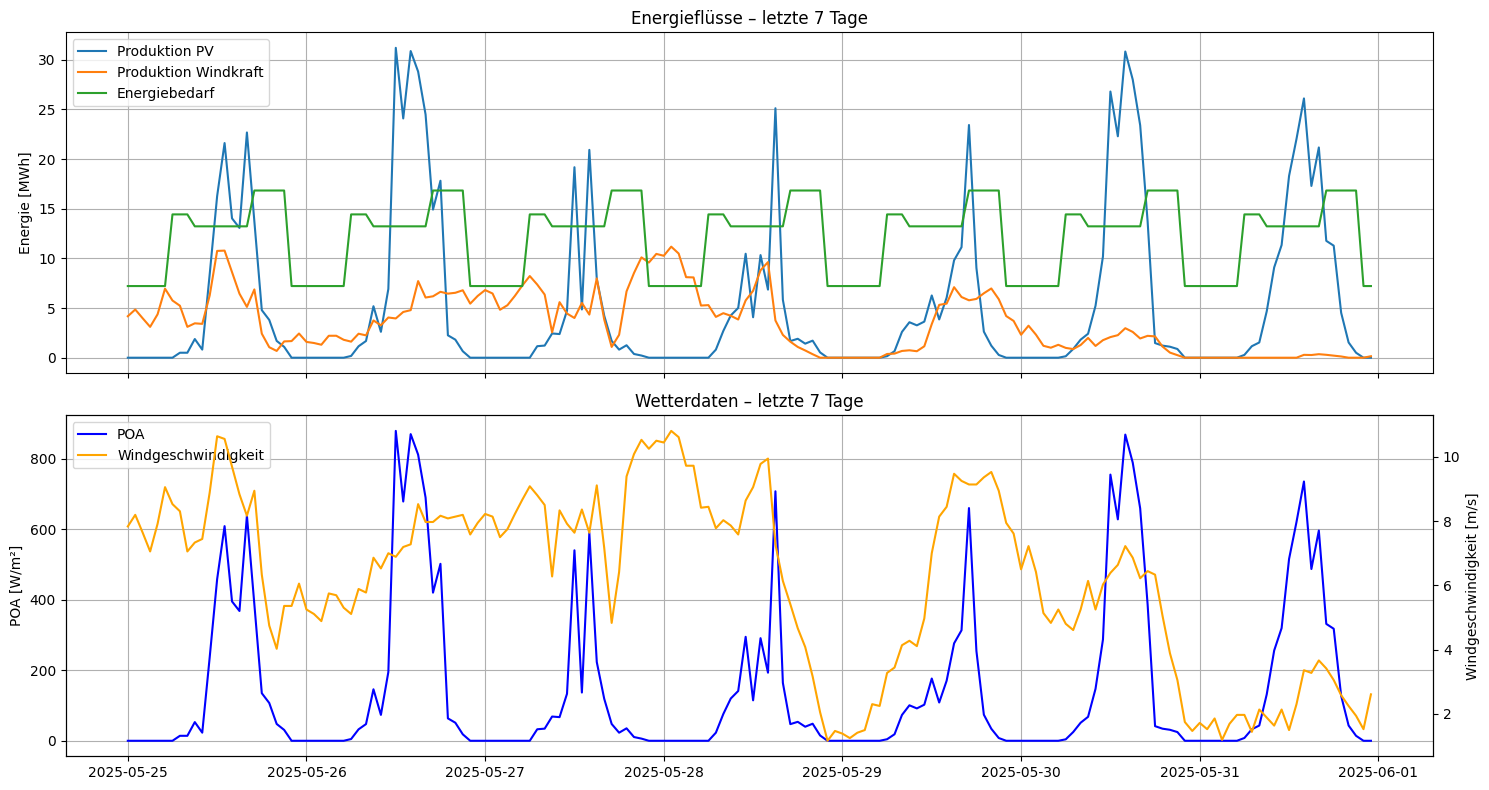

In [13]:
# Letzte 7 Tage extrahieren
df_plot = df_energy.copy().set_index("datetime").last("7D")

# Figure mit zwei Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Energieflüsse
ax1.plot(df_plot.index, df_plot["solar_energy_production"], label="Produktion PV")
ax1.plot(df_plot.index, df_plot["wind_energy_production"], label="Produktion Windkraft")
ax1.plot(df_plot.index, df_plot["energy_demand"], label="Energiebedarf")
ax1.set_ylabel("Energie [MWh]")
ax1.set_title("Energieflüsse – letzte 7 Tage")
ax1.legend()
ax1.grid(True)

# Wetterdaten
ax2a = ax2  # linke Achse
ax2b = ax2a.twinx()  # rechte Achse

line1, = ax2a.plot(df_plot.index, df_plot["poa_irradiance"], color="blue", label="POA")
line2, = ax2b.plot(df_plot.index, df_plot["windspeed"] / 3.6, color="orange", label="Windgeschwindigkeit")

ax2a.set_ylabel("POA [W/m²]")
ax2a.tick_params(axis='y')
ax2b.set_ylabel("Windgeschwindigkeit [m/s]")
ax2b.tick_params(axis='y')
ax2a.set_title("Wetterdaten – letzte 7 Tage")

# Gemeinsame Legende unten
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax2.grid(True)
ax2a.legend(lines, labels, loc="upper left")

plt.xlabel("Zeit")
plt.tight_layout()
plt.show()


**Vorbereiten des Spot-Preis Datensatzes und Mergen mit Enegrieprod. Datensatz**

In [14]:
df_spot = get_spotprice()
if df_spot is None:
    print("Abbruch.")

df_spot.head()

df_energy_spot = df_energy.copy()
df_energy_spot = df_energy_spot.merge(df_spot[["datetime", "spotprice"]], on="datetime", how="left")

display(df_energy_spot.head())


# Check auf NaN-Elemente
print("Anzahl NaN-Werte pro Spalte:")
print(df_energy_spot.isna().sum())


,datetime,windspeed,poa_irradiance,solar_energy_production,wind_energy_production,energy_demand,total_energy_production,spotprice
0,2025-05-24 23:00:00,25.2,0.0,0.0,2.957871,7.212329,2.957871,7.967
1,2025-05-25 00:00:00,28.2,0.0,0.0,4.174387,7.212329,4.174387,2.382
2,2025-05-25 01:00:00,29.5,0.0,0.0,4.850955,7.212329,4.850955,2.290
3,2025-05-25 02:00:00,27.5,0.0,0.0,3.966791,7.212329,3.966791,1.439
4,2025-05-25 03:00:00,25.4,0.0,0.0,3.106123,7.212329,3.106123,0.838


Anzahl NaN-Werte pro Spalte:
datetime                   0
windspeed                  0
poa_irradiance             0
solar_energy_production    0
wind_energy_production     0
energy_demand              0
total_energy_production    0
spotprice                  0
dtype: int64


**Ausführen der regelbasierten und optimierten Funktion**

In [15]:
# Optimierungsfunktionen
result_df_rule, result_kpis_rule = rule_based_energy_flow(
    df_energy_spot, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )


result_df_opt, result_kpis_opt = optimize_energy_flow(
    df_energy_spot, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor
    )

**Ausgabe der wichtigsten KPIs zum quanitiativen Vergleich der Performance**

In [ ]:
#Ausgaben 
print("Regelbasiert:")
print(f"Netto Stromkosten: {result_kpis_rule['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_rule['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_rule['Einspeisevergütung']:.2f} €")
wavg_price_rule = (result_df_rule["spotprice_EUR_per_MWh"] * result_df_rule["ee_export_MWh"]).sum() / max(result_kpis_rule["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (rule): {wavg_price_rule:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_rule['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_rule['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_rule['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_rule['Batterieentladung']:.2f} MWh")

print("----------------------")

print("Optimiert:")
print(f"Netto Stromkosten: {result_kpis_opt['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_opt['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_opt['Einspeisevergütung']:.2f} €")
wavg_price_opt = (result_df_opt["spotprice_EUR_per_MWh"] * result_df_opt["ee_export_MWh"]).sum() / max(result_kpis_opt["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (opt):  {wavg_price_opt:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_opt['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_opt['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_opt['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_opt['Batterieentladung']:.2f} MWh")

print("----------------------")

# Differenz Optimiert - Regelbasiert
diff_eur = result_kpis_opt["Netto Stromkosten"] - result_kpis_rule["Netto Stromkosten"]
rel_pct  = diff_eur / result_kpis_rule["Netto Stromkosten"] * 100
demand_MWh = result_df_opt["demand_MWh"].sum()  # Referenz für ct/kWh

print(f"Einsparungspotenzial: {diff_eur:.2f} € ({rel_pct:.2f} %)")
months = len(df_weather) / 24
saving_per_month = diff_eur / months
print(f"Ø tägliche Einsparung: {saving_per_month:.2f} €")



Regelbasiert:
Netto Stromkosten: 72150.03 €
Netzstromkosten: 72502.36 €
Einspeisevergütung: 352.33 €
Export-gewichteter Preis (rule): 3.99 €/MWh
Netzbezug: 907.80 MWh
Einspeisung: 352.98 MWh
Batterieladung: 137.77 MWh
Batterieentladung: 143.77 MWh
----------------------
Optimiert:
Netto Stromkosten: 64270.64 €
Netzstromkosten: 64481.35 €
Einspeisevergütung: 210.71 €
Export-gewichteter Preis (opt):  1.21 €/MWh
Netzbezug: 1254.20 MWh
Einspeisung: 699.38 MWh
Batterieladung: 167.12 MWh
Batterieentladung: 173.12 MWh
----------------------
Einsparungspotenzial: -7879.39 € (-10.92 %)
Ø monatliche Einsparung: -1118.97 €


**Zwischenfazit (13.08.):**
- Preisdifferenz im gesamten Zeitraum von fast 8000€ und <10%
- Preisdifferenz von ca. 1100€/Tag 
- Höhrer Netzbezug in Optimierung -> Funktion geht auf den dynamischen Strompreis ein
- In beiden Fällen sehr geringe Einspeisevergütungen -> Es wird bei Lastüberschuss eingespeist, die Strompreise sind dann i.d.R gering wenn nicht negativ
- Optimierte Funktion nutzt die Batterie mehr -> höhere Effizienz

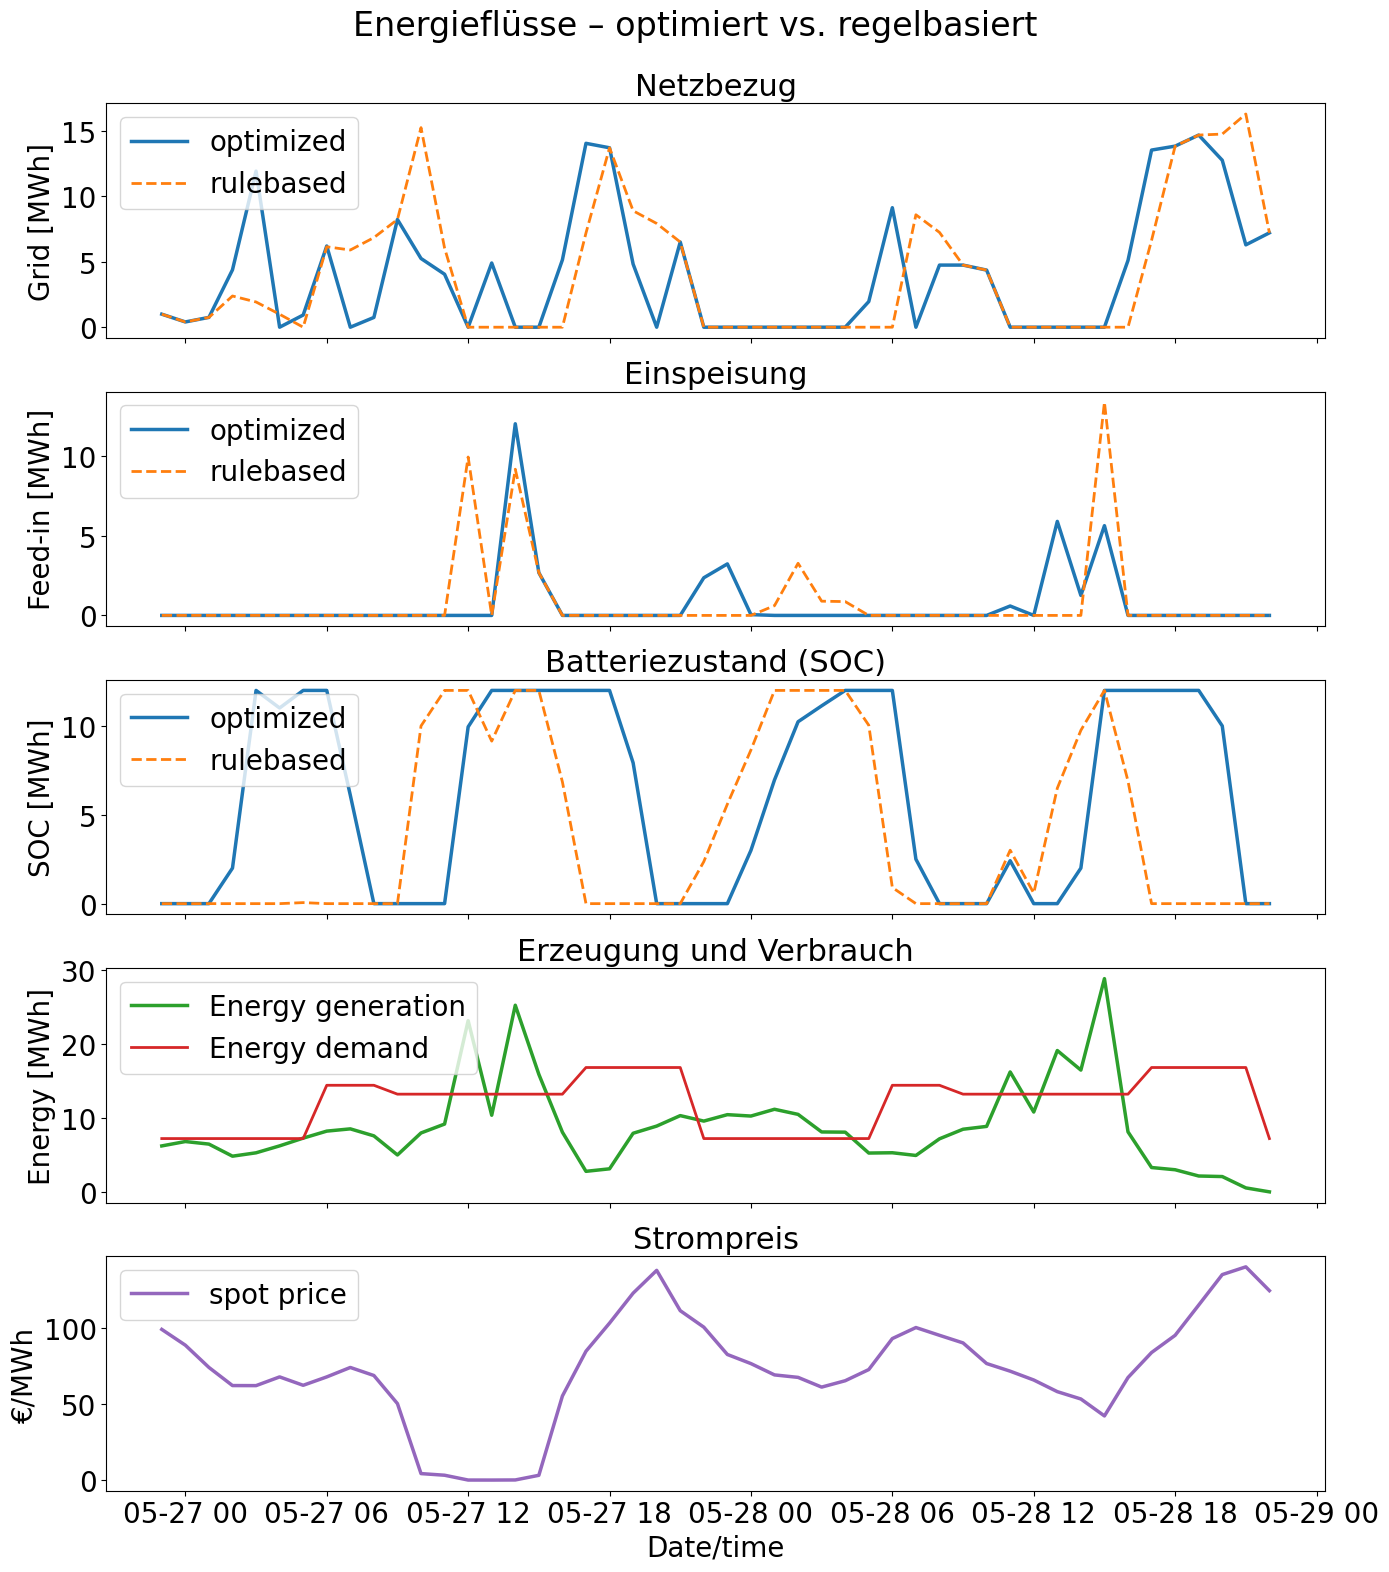

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Zeitspalten
result_df_opt["datetime"] = pd.to_datetime(result_df_opt["datetime"])
result_df_rule["datetime"] = pd.to_datetime(result_df_rule["datetime"])

# Kopien + Hilfsspalten
opt  = result_df_opt.copy()
rule = result_df_rule.copy()
for df in (opt, rule):
    df["grid_buy"]      = df["grid_to_load_MWh"] + df["grid_to_batt_MWh"]
    df["battery_state"] = df["SOC_MWh"]
    df["grid_feed_in"]  = df["ee_export_MWh"]

# Zeitfenster
start_time = opt["datetime"].min() + pd.Timedelta(days=1)
end_time   = start_time + pd.Timedelta(days=3)
opt  = opt[(opt["datetime"] >= start_time) & (opt["datetime"] < end_time)]
rule = rule[(rule["datetime"] >= start_time) & (rule["datetime"] < end_time)]

# Styles
label_fontsize = 20
tick_fontsize  = 20
legend_fontsize= 20
title_fontsize = 22
c_opt  = "tab:blue"
c_rule = "tab:orange"
c_gen  = "tab:green"
c_dem  = "tab:red"
c_prc  = "tab:purple"

# Plot
fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)
fig.suptitle("Energieflüsse – optimiert vs. regelbasiert", fontsize=title_fontsize+2)

# 1) Netzbezug
axs[0].set_title("Netzbezug", fontsize=title_fontsize)
axs[0].plot(opt["datetime"],  opt["grid_buy"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[0].plot(rule["datetime"], rule["grid_buy"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[0].set_ylabel("Grid [MWh]", fontsize=label_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# 2) Einspeisung
axs[1].set_title("Einspeisung", fontsize=title_fontsize)
axs[1].plot(opt["datetime"],  opt["grid_feed_in"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[1].plot(rule["datetime"], rule["grid_feed_in"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[1].set_ylabel("Feed-in [MWh]", fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

# 3) Batteriezustand
axs[2].set_title("Batteriezustand (SOC)", fontsize=title_fontsize)
axs[2].plot(opt["datetime"],  opt["battery_state"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[2].plot(rule["datetime"], rule["battery_state"], label="regelbasiertertertert", color=c_rule, linestyle="--", linewidth=2)
axs[2].set_ylabel("SOC [MWh]", fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

# 4) Erzeugung und Verbrauch
axs[3].set_title("Erzeugung und Verbrauch", fontsize=title_fontsize)
axs[3].plot(opt["datetime"], opt["EE_total_MWh"], label="Energy generation", color=c_gen, linewidth=2.5)
axs[3].plot(opt["datetime"], opt["demand_MWh"],     label="Energy demand",    color=c_dem, linewidth=2)
axs[3].set_ylabel("Energy [MWh]", fontsize=label_fontsize)
axs[3].legend(fontsize=legend_fontsize)
axs[3].tick_params(axis='both', labelsize=tick_fontsize)

# 5) Strompreis
axs[4].set_title("Strompreis", fontsize=title_fontsize)
axs[4].plot(opt["datetime"], opt["spotprice_EUR_per_MWh"], label="spot price", color=c_prc, linewidth=2.5)
axs[4].set_ylabel("€/MWh", fontsize=label_fontsize)
axs[4].legend(fontsize=legend_fontsize)
axs[4].tick_params(axis='both', labelsize=tick_fontsize)

plt.xlabel("Date/time", fontsize=label_fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


**Plot der Energieflüsse zum qualitativen Vergleich der Performance**

KeyError: 'grid_buy'

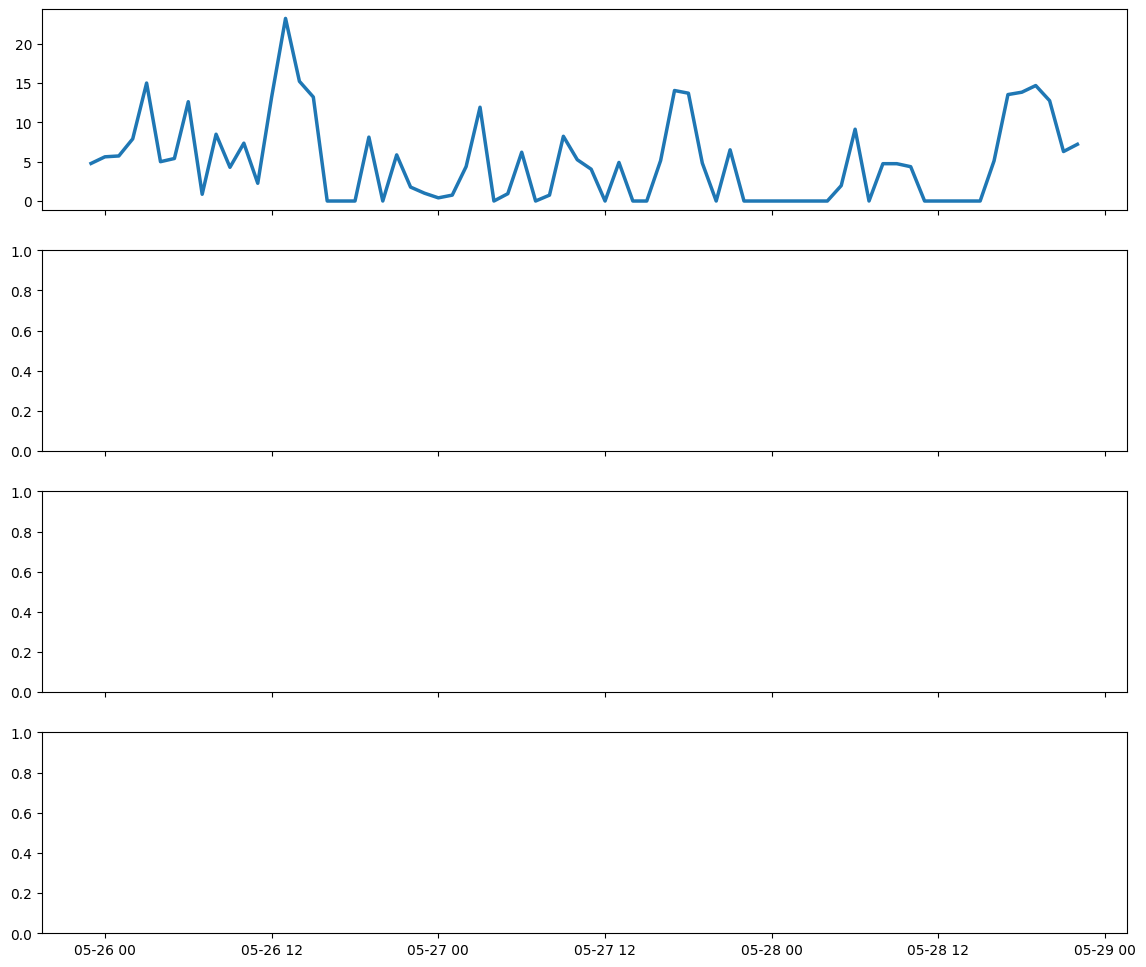

In [ ]:
#Plots erstellen

# Zeitspalte parsen
result_df_opt["datetime"] = pd.to_datetime(result_df_opt["datetime"])
result_df_rule["datetime"] = pd.to_datetime(result_df_rule["datetime"])

# Filter: nur die ersten beiden Tage
start_time = result_df_opt["datetime"].min()
start_time = start_time + pd.Timedelta(days=1)
end_time = start_time + pd.Timedelta(days=3)

result_df_opt = result_df_opt[(result_df_opt["datetime"] >= start_time) & (result_df_opt["datetime"] < end_time)]
result_df_rule = result_df_rule[(result_df_rule["datetime"] >= start_time) & (result_df_rule["datetime"] < end_time)]

# Schriftgrößen definieren
label_fontsize = 20
tick_fontsize = 20
legend_fontsize = 20

# Plot erstellen
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Netzbezug
axs[0].plot(result_df_opt["datetime"], result_df_opt["grid_buy"], label="optimiert", linewidth=2.5)
axs[0].plot(result_df_rule["datetime"], result_df_rule["grid_buy"], label="regelbasiert", color="black", linestyle="--", linewidth=2)
axs[0].set_ylabel("Grid electricity [MWh]", fontsize=label_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# Curtailment vs. Feed-in
axs[1].plot(result_df_opt["datetime"], result_df_opt["curtailment"], label="optimiert", color="orange", linewidth=2.5)
axs[1].plot(result_df_rule["datetime"], result_df_rule["grid_feed_in"], label="regelbasiert", color="black", linestyle="--", linewidth=2)
axs[1].set_ylabel("Feed-in [MWh]", fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

# Batteriezustand
axs[2].plot(result_df_opt["datetime"], result_df_opt["battery_state"], label="optimiert", color="green", linewidth=2.5)
axs[2].plot(result_df_rule["datetime"], result_df_rule["battery_state"], label="regelbasiert", color="black", linestyle="--", linewidth=2)
axs[2].set_ylabel("SOC [MWh]", fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

# Erzeugung und Verbrauch
axs[3].plot(result_df_opt["datetime"], result_df_opt["total_energy_production"], label="Energy generation", color="purple", linewidth=2.5)
axs[3].plot(result_df_opt["datetime"], result_df_opt["energy_demand"], label="Energy demand", linestyle="--", color="black", linewidth=2)
axs[3].set_ylabel("Energy quantity [MWh]", fontsize=label_fontsize)
axs[3].legend(fontsize=legend_fontsize)
axs[3].tick_params(axis='both', labelsize=tick_fontsize)

# Gemeinsame X-Achse
plt.xlabel("Date/time", fontsize=label_fontsize)
plt.tight_layout()
plt.show()